# Исследовательский проект - разработка модели для прогноза оттоков клиентов интернет-магазина «В один клик» (автор Косульников Ю.В.)

Ссылка на проект на GitHub: https://github.com/YVKosulnikov/supervised_learning.git

## Введение и цель исследования

Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Цель исследования - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

<p>Этапы исследования:</p>
<ul>
<li>Загрузка библиотек, выгрузка данных и настройка отображений датасетов</li>
<li>Загрузка данных</li>
<li>Определение функций по отрисовке графиков</li>  
<li>Предобработка данных</li>
<li>Исследовательский анализ данных</li>
<li>Объединение таблиц</li>
<li>Корреляционный анализ</li>
<li>Использование пайплайнов</li>
<li>Анализ важности признаков</li>
<li>Сегментация покупателей¶</li>
<li>Общий вывод</li>
</ul>

## Загрузка библиотек, выгрузка данных и настройка отображений датасетов

In [ ]:
!pip install seaborn -q
!pip install phik -q
!pip install shap -q
! pip install --upgrade scikit-learn -q

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phik
import shap
import warnings
import seaborn as sns

from ipywidgets import interact, IntSlider
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error,
                             r2_score,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.inspection import permutation_importance

from sklearn.exceptions import ConvergenceWarning

sns.set_style('whitegrid')
sns.set_context("notebook")

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.precision', 2)
pd.set_option('display.max_colwidth', 2)

In [ ]:
# Константы
RANDOM_STATE = 42

## Загрузка данных

In [ ]:
pth1 = '/datasets/market_file.csv'
pth2 = '/datasets/market_money.csv'
pth3 = '/datasets/market_time.csv'
pth4 = '/datasets/money.csv'

if (os.path.exists(pth1) and
    os.path.exists(pth2) and
    os.path.exists(pth3) and
    os.path.exists(pth4)):
        market_file = pd.read_csv(pth1)
        market_money = pd.read_csv(pth2)
        market_time = pd.read_csv(pth3)
        money = pd.read_csv(pth4, sep=';')
else:
    print('Something is wrong')

## Определение функций по отрисовке графиков

In [ ]:
# Функция для построения графика
def plot_construct(X, y):
    end = start + window_size
    
    plt.figure(figsize=(15, 6))
    plt.plot(X, y, label='Кривая зависимости y от X', color='blue')

    plt.xlabel('Значения по оси X')
    plt.ylabel('Значения по оси Y')

    # plt.yticks(np.arange(0, 101, 10))
    # plt.xticks(rotation=45)
    # plt.gca().yaxis.set_minor_locator(MultipleLocator())
    # plt.gca().xaxis.set_minor_locator(MultipleLocator())
    
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    
    plt.title(f'Заголовок зависимости y от X')
    plt.legend()
    plt.show()

def val_category_count(df, column):
    plt.figure(figsize=(15, 7.5))
    value_counts = df[column].value_counts().sort_values(ascending=False)
    plot = sns.countplot(y=column, data=df, order=value_counts.index)
    plot.set_title(f'Распределение значений {column}', fontsize=15)
    plot.set_xlabel('Количество', fontsize=15)
    plt.show()
    
def bar_construct(df, column):
    plt.figure(figsize=(15, 7.5))
    plot = sns.barplot(data=df, x=column, y=df.index)
    plot.set_title(f'Столбчатая диаграмма по {column}', fontsize=15)
    plot.set_xlabel('Категории', fontsize=15)
    
    
def boxplot_and_histplot_construct(df, column, target=None):
    sns.set()
    fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
    axes[0].set_title(f'Boxplot для столбца "{column}"', fontsize=15)
    sns.boxplot(data=df, ax=axes[0], y=column)
    axes[0].set_ylabel(column, fontsize=15)
    axes[1].set_title(f'Гистограмма для столбца "{column}"', fontsize=15)
    axes[1].set_ylabel('количество наблюдений', fontsize=15)
    if target != None:
        sns.histplot(df, bins=25, kde=True, ax=axes[1], hue=target, x=column)
    else:
        sns.histplot(df, bins=25, kde=True, ax=axes[1], x=column)

    plt.show()

## Предобработка данных

### Предобработка данных первой таблицы

In [ ]:
market_file_origin = market_file.copy()

In [ ]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [ ]:
market_file.columns = market_file.columns.str.lower().str.strip().str.replace(' ', '_')

In [ ]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [ ]:
for category in market_file.select_dtypes(exclude='number').columns.tolist():
    market_file[category] = market_file[category].str.lower().str.strip().str.replace(' ', '_')

In [ ]:
print(f"""
    В таблице market_file:
    {len(market_file)} строк,
    {len(market_file.columns)} столбцов,
    Название столбцов:
    {list(market_file.columns)},
    Числовые столбцы:
    {list(market_file.select_dtypes(include='number').columns.tolist())},
    Категориальные столбцы (название, число категорий):
    {list(zip(list(market_file.select_dtypes(exclude='number').columns.tolist()), list(market_file.select_dtypes(exclude='number').nunique())))},
    {market_file.duplicated().sum()} явных дубликатов,
    {market_file.duplicated(subset=['id']).sum()} дублей по id,
    {market_file.duplicated(subset=[
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит'
    ]).sum()} неявных дублей (т.е. дублей по маркет_актив_6_мес, маркет_актив_тек_мес, длительность, акционные_покупки, средний_просмотр_категорий_за_визит)
    {market_file.isna().sum().sum()} строк с пропусками
    """
     )


    В таблице market_file:
    1300 строк,
    13 столбцов,
    Название столбцов:
    ['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит'],
    Числовые столбцы:
    ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит'],
    Категориальные столбцы (название, число категорий):
    [('покупательская_активность', 2), ('тип_сервиса', 3), ('разрешить_сообщать', 2), ('популярная_категория', 6)],
    0 явных дубликатов,
    0 дублей по id,
    12 неявных дублей (т.е. дублей по маркет_актив_6_мес, маркет_актив_тек_мес, длительность, акционные_покупки, средний_просмотр_категорий_за_визит)
    0 строк с проп

Удаляем строки с выявленными неявными дубликатами

In [ ]:
market_file = market_file.loc[~(market_file.duplicated(subset=[
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит'
    ]))]
market_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1288 non-null   int64  
 1   покупательская_активность            1288 non-null   object 
 2   тип_сервиса                          1288 non-null   object 
 3   разрешить_сообщать                   1288 non-null   object 
 4   маркет_актив_6_мес                   1288 non-null   float64
 5   маркет_актив_тек_мес                 1288 non-null   int64  
 6   длительность                         1288 non-null   int64  
 7   акционные_покупки                    1288 non-null   float64
 8   популярная_категория                 1288 non-null   object 
 9   средний_просмотр_категорий_за_визит  1288 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1288 non-null   int64  
 11  ошибка_сервиса                

In [ ]:
print('Уникальные значения категориальных столбцов:')
print()
for category in market_file.select_dtypes(exclude='number').columns.tolist():
    market_file[category] = market_file[category].str.lower().str.strip().str.replace(' ', '_')
    print(category, market_file[category].unique())

Уникальные значения категориальных столбцов:

покупательская_активность ['снизилась' 'прежний_уровень']
тип_сервиса ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать ['да' 'нет']
популярная_категория ['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']


In [ ]:
market_file.loc[market_file['популярная_категория'] == 'косметика_и_аксесуары', 'популярная_категория'] = 'косметика_и_аксессуары'
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'

In [ ]:
print(f"""
В результате предобработки первого датасета удалено:
{len(market_file_origin) - len(market_file)} строк или {round((len(market_file_origin) - len(market_file))/len(market_file_origin),2)}%""")


В результате предобработки первого датасета удалено:
12 строк или 0.01%


### Предобработка данных второй таблицы

In [ ]:
market_money_origin = market_money.copy()

In [ ]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [ ]:
market_money.columns = market_money.columns.str.lower().str.strip().str.replace(' ', '_')

In [ ]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [ ]:
for category in market_money.select_dtypes(exclude='number').columns.tolist():
    market_money[category] = market_money[category].str.lower().str.strip().str.replace(' ', '_')

In [ ]:
print(f"""
    В таблице market_money:
    {len(market_money)} строк,
    {len(market_money.columns)} столбцов,
    Название столбцов:
    {list(market_money.columns)},
    Числовые столбцы:
    {list(market_money.select_dtypes(include='number').columns.tolist())},
    Категориальные столбцы (название, число категорий):
    {list(zip(list(market_money.select_dtypes(exclude='number').columns.tolist()), list(market_money.select_dtypes(exclude='number').nunique())))},
    {market_money.duplicated().sum()} явных дубликатов,
    {market_money.duplicated(subset=['id']).sum()} дублей по id,
    {market_money.isna().sum().sum()} строк с пропусками
    """
     )


    В таблице market_money:
    3900 строк,
    3 столбцов,
    Название столбцов:
    ['id', 'период', 'выручка'],
    Числовые столбцы:
    ['id', 'выручка'],
    Категориальные столбцы (название, число категорий):
    [('период', 3)],
    0 явных дубликатов,
    2600 дублей по id,
    0 строк с пропусками
    


In [ ]:
print('Уникальные значения категориальных столбцов:')
print()
for category in market_money.select_dtypes(exclude='number').columns.tolist():
    market_money[category] = market_money[category].str.lower().str.strip().str.replace(' ', '_')
    print(category, market_money[category].unique())

Уникальные значения категориальных столбцов:

период ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [ ]:
print(f"""
В результате предобработки второго датасета удалено:
{len(market_money_origin) - len(market_money)} строк или {round((len(market_money_origin) - len(market_money))/len(market_money_origin),2)}%""")


В результате предобработки второго датасета удалено:
0 строк или 0.0%


### Предобработка данных третьей таблицы

In [ ]:
market_time_origin = market_time.copy()

In [ ]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [ ]:
market_time.columns = market_time.columns.str.lower().str.strip().str.replace(' ', '_')

In [ ]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [ ]:
for category in market_time.select_dtypes(exclude='number').columns.tolist():
    market_time[category] = market_time[category].str.lower().str.strip().str.replace(' ', '_')

In [ ]:
print(f"""
    В таблице market_time:
    {len(market_time)} строк,
    {len(market_time.columns)} столбцов,
    Название столбцов:
    {list(market_time.columns)},
    Числовые столбцы:
    {list(market_time.select_dtypes(include='number').columns.tolist())},
    Категориальные столбцы (название, число категорий):
    {list(zip(list(market_money.select_dtypes(exclude='number').columns.tolist()), list(market_money.select_dtypes(exclude='number').nunique())))},
    {market_time.duplicated().sum()} явных дубликатов,
    {market_time.duplicated(subset=['id']).sum()} дублей по id,
    {market_time.isna().sum().sum()} строк с пропусками
    """
     )


    В таблице market_time:
    2600 строк,
    3 столбцов,
    Название столбцов:
    ['id', 'период', 'минут'],
    Числовые столбцы:
    ['id', 'минут'],
    Категориальные столбцы (название, число категорий):
    [('период', 3)],
    0 явных дубликатов,
    1300 дублей по id,
    0 строк с пропусками
    


In [ ]:
print('Уникальные значения категориальных столбцов:')
print()
for category in market_time.select_dtypes(exclude='number').columns.tolist():
    market_time[category] = market_time[category].str.lower().str.strip().str.replace(' ', '_')
    print(category, market_time[category].unique())

Уникальные значения категориальных столбцов:

период ['текущий_месяц' 'предыдцщий_месяц']


In [ ]:
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

In [ ]:
print(f"""
В результате предобработки третьего датасета удалено:
{len(market_time_origin) - len(market_time)} строк или {round((len(market_time) - len(market_time))/len(market_time),2)}%""")


В результате предобработки третьего датасета удалено:
0 строк или 0.0%


### Предобработка данных четвертой таблицы

In [ ]:
money_origin = money.copy()

In [ ]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [ ]:
money.columns = money.columns.str.lower().str.strip().str.replace(' ', '_')

In [ ]:
money.head()

,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [ ]:
for category in money.select_dtypes(exclude='number').columns.tolist():
    money[category] = money[category].str.lower().str.strip().str.replace(' ', '_').str.replace(',', '.')
    money[category] = money[category].astype('float', errors='ignore')

In [ ]:
print(f"""
    В таблице money:
    {len(money)} строк,
    {len(money.columns)} столбцов,
    Название столбцов:
    {list(money.columns)},
    Числовые столбцы:
    {list(money.select_dtypes(include='number').columns.tolist())},
    Категориальные столбцы (название, число категорий):
    {list(zip(list(money.select_dtypes(exclude='number').columns.tolist()), list(money.select_dtypes(exclude='number').nunique())))},
    {money.duplicated().sum()} явных дубликатов,
    {money.duplicated(subset=['id']).sum()} дублей по id,
    {money.isna().sum().sum()} строк с пропусками
    """
     )


    В таблице money:
    1300 строк,
    2 столбцов,
    Название столбцов:
    ['id', 'прибыль'],
    Числовые столбцы:
    ['id', 'прибыль'],
    Категориальные столбцы (название, число категорий):
    [],
    0 явных дубликатов,
    0 дублей по id,
    0 строк с пропусками
    


In [ ]:
print(f"""
В результате предобработки четвертого датасета удалено:
{len(money_origin) - len(money)} строк или {round((len(money) - len(money))/len(money),2)}%""")


В результате предобработки четвертого датасета удалено:
0 строк или 0.0%


## Исследовательский анализ данных

### Исследовательский анализ данных первой таблицы

In [ ]:
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1288.00,1288.00,1288.00,1288.00,1288.00,1288.00,1288.00,1288.00,1288.00
mean,215998.41,4.25,4.01,601.69,0.32,3.28,2.84,4.19,8.16
std,377.05,1.02,0.70,249.97,0.25,1.36,1.97,1.96,3.98
min,215348.00,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,215669.75,3.70,4.00,404.00,0.17,2.00,1.00,3.00,5.00
50%,216003.50,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,216325.25,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,216647.00,6.60,5.00,1079.00,0.99,6.00,10.00,9.00,20.00


<p>Анализ по столбцам:</p>
    <ul>
        <li>маркет_актив_6_мес - без аномалий (выбросов)</li>
        <li>маркет_актив_тек_мес - без аномалий (выбросов)</li>
        <li>длительность - без аномалий (выбросов)</li>
        <li>акционные_покупки - существенно смещающие средние относительно медианы максимальные значения</li>
        <li>средний_просмотр_категорий_за_визит - без аномалий (выбросов)</li>
        <li>неоплаченные_продукты_штук_квартал - без аномалий (выбросов)</li>
        <li>ошибка_сервиса - без аномалий (выбросов)</li>
        <li>страниц_за_визит - без аномалий (выбросов)</li>    
    </ul>

Визуализируем боксплот и гистограмму по отобранным столбцам.

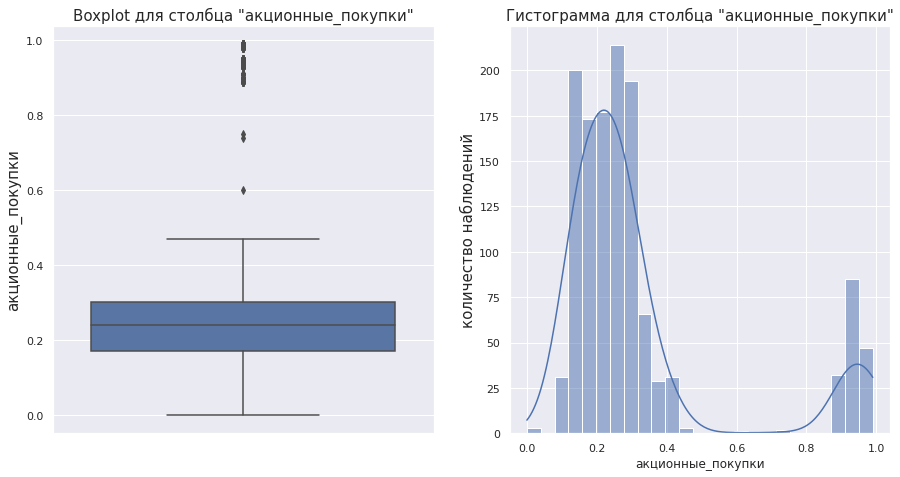

In [ ]:
boxplot_and_histplot_construct(market_file, 'акционные_покупки')

Наблюдаем, что значения признака 'акционные_покупки' явно разделяется на 2 группы - 0.0-0.5 и 0.9-1.0

Проанализируем распределения остальных числовых признаков.

Данные по столбцу с числовыми показателями АКЦИОННЫЕ_ПОКУПКИ
count    1288.00
mean     0.32   
std      0.25   
min      0.00   
25%      0.17   
50%      0.24   
75%      0.30   
max      0.99   
Name: акционные_покупки, dtype: float64


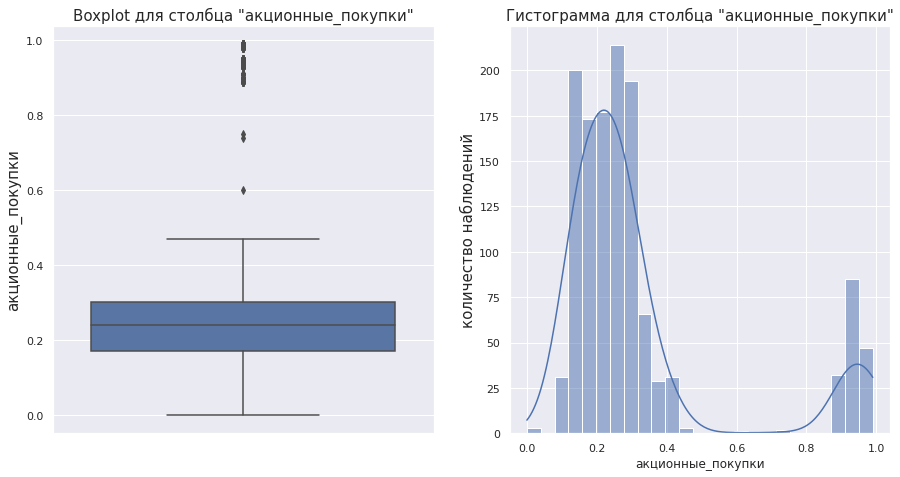

Данные по столбцу с числовыми показателями ДЛИТЕЛЬНОСТЬ
count    1288.00
mean     601.69 
std      249.97 
min      110.00 
25%      404.00 
50%      606.00 
75%      806.00 
max      1079.00
Name: длительность, dtype: float64


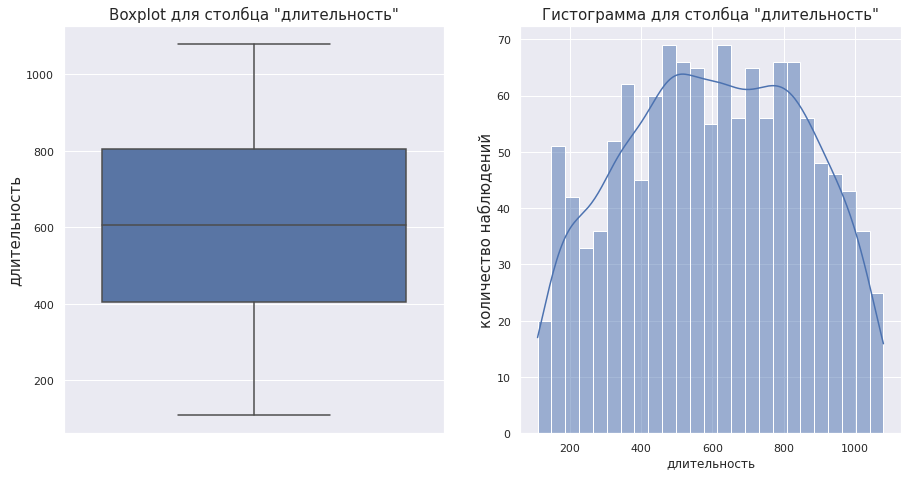

In [ ]:
for column in ['акционные_покупки', 'длительность']:
    print(f'Данные по столбцу с числовыми показателями {column.upper()}')
    print(market_file[column].describe())
    boxplot_and_histplot_construct(market_file, column)
    plt.show()

In [ ]:
market_file

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,прежний_уровень,стандарт,да,6.6,3,318,0.24,техника_для_красоты_и_здоровья,5,3,3,11
1296,216644,прежний_уровень,стандарт,нет,5.1,4,454,0.21,домашний_текстиль,6,2,3,9
1297,216645,прежний_уровень,стандарт,да,4.1,3,586,0.20,домашний_текстиль,3,2,5,7
1298,216646,прежний_уровень,стандарт,да,6.3,5,645,0.12,техника_для_красоты_и_здоровья,3,3,5,7


Данные по столбцу с категориальными показателями СРЕДНИЙ_ПРОСМОТР_КАТЕГОРИЙ_ЗА_ВИЗИТ


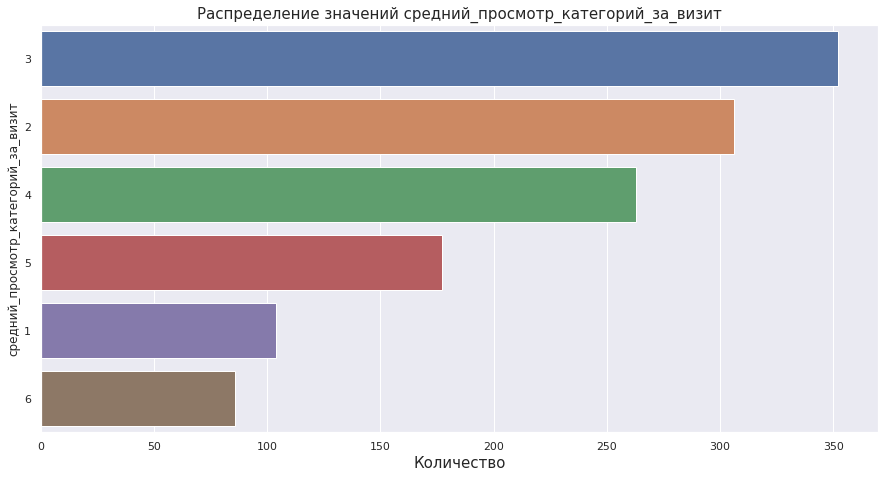

Данные по столбцу с категориальными показателями НЕОПЛАЧЕННЫЕ_ПРОДУКТЫ_ШТУК_КВАРТАЛ


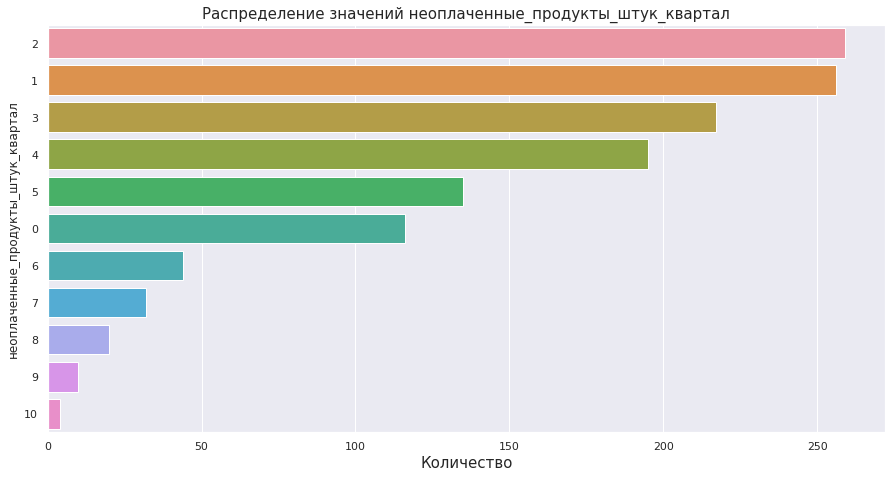

Данные по столбцу с категориальными показателями ОШИБКА_СЕРВИСА


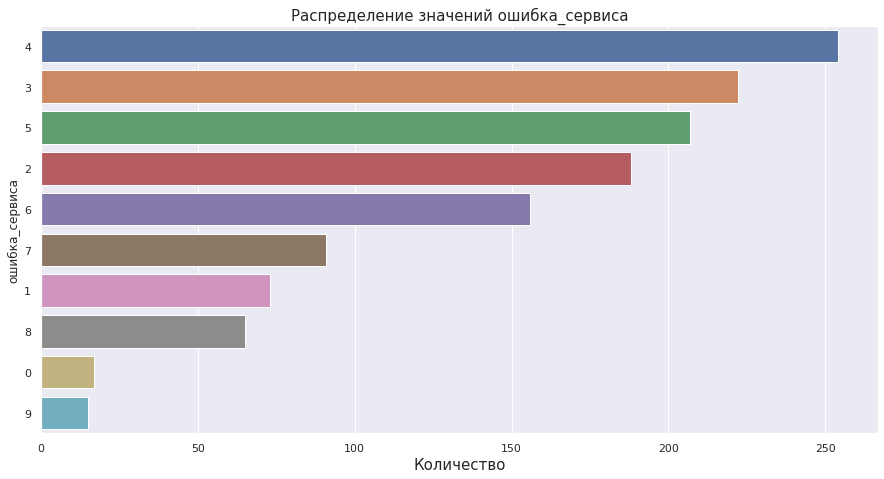

Данные по столбцу с категориальными показателями СТРАНИЦ_ЗА_ВИЗИТ


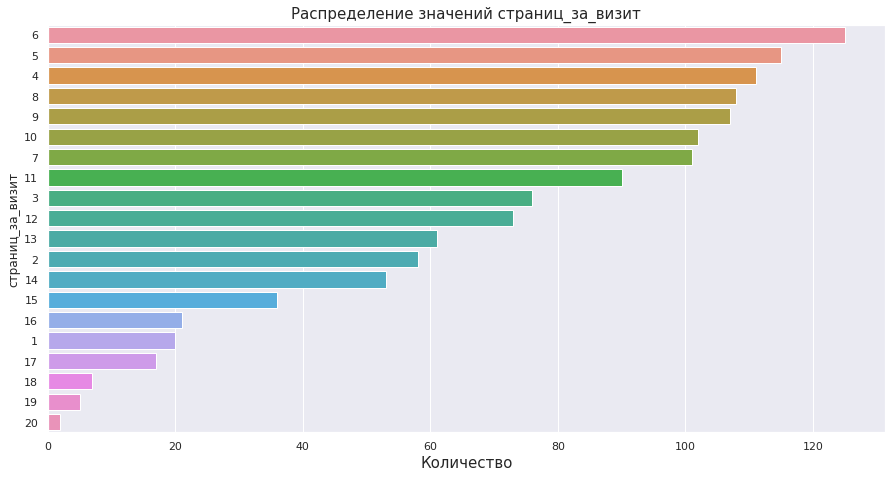

In [ ]:
for column in ['средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']:
    print(f'Данные по столбцу с категориальными показателями {column.upper()}')
    val_category_count(market_file, column)
    plt.show()

Показано, что в значениях 'маркет_актив_6_мес' выделется небольшая группа клиентов, в отношении которых оказывали малую марк. активность в 1-2 балла. Но вввиду ее малочисленности разбивать значения на 2 категории 'марк_активные' и 'марк_не_активные' 

Обращает на себя внимание существнная разности по популярности категорий товаров, что можно использовать для составления пользовательских профилей и формирования персонализированных маркетинговых предложений.

### Исследовательский анализ данных второй таблицы

In [ ]:
market_money.describe()

,id,выручка
count,3900.00,3900.00
mean,215997.50,5025.70
std,375.33,1777.70
min,215348.00,0.00
25%,215672.75,4590.15
50%,215997.50,4957.50
75%,216322.25,5363.00
max,216647.00,106862.20


<p>Анализ по столбцам:</p>
    <ul>
        <li>выручка - существенно смещающие средние относительно медианы максимальные значения</li>
    </ul>

Визуализируем боксплот и гистограмму по отобранным столбцам.

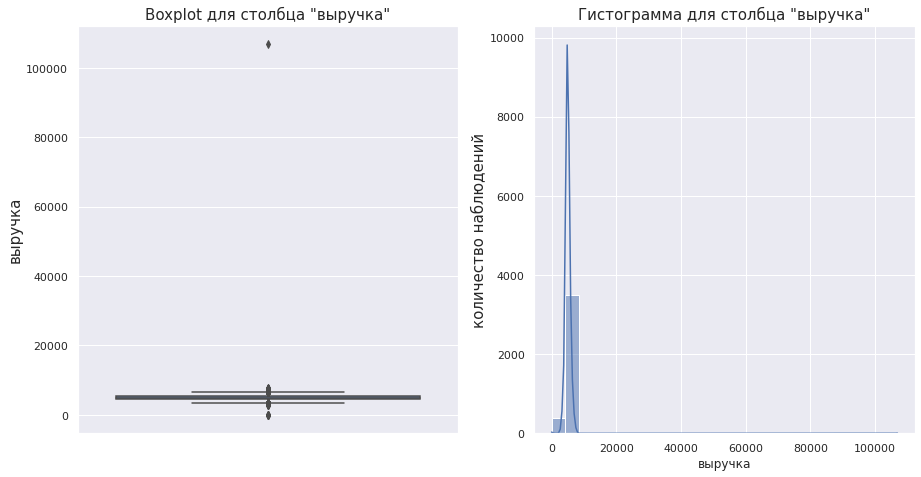

In [ ]:
boxplot_and_histplot_construct(market_money, 'выручка')

Наблюдаем выбросы по значению выручки, фильтруем данные по 99 процентилю

In [ ]:
market_money_percentile_99 = market_money['выручка'].quantile(0.99)
super_client_id = market_money.loc[market_money['выручка'] >= market_money_percentile_99, 'id']

### Исследовательский анализ данных третьей таблицы

In [ ]:
market_time.describe()

,id,минут
count,2600.00,2600.00
mean,215997.50,13.34
std,375.35,4.08
min,215348.00,4.00
25%,215672.75,10.00
50%,215997.50,13.00
75%,216322.25,16.00
max,216647.00,23.00


<p>Анализ по столбцам:</p>
    <ul>
        <li>минут - без аномалий (выбросов)</li>
    </ul>

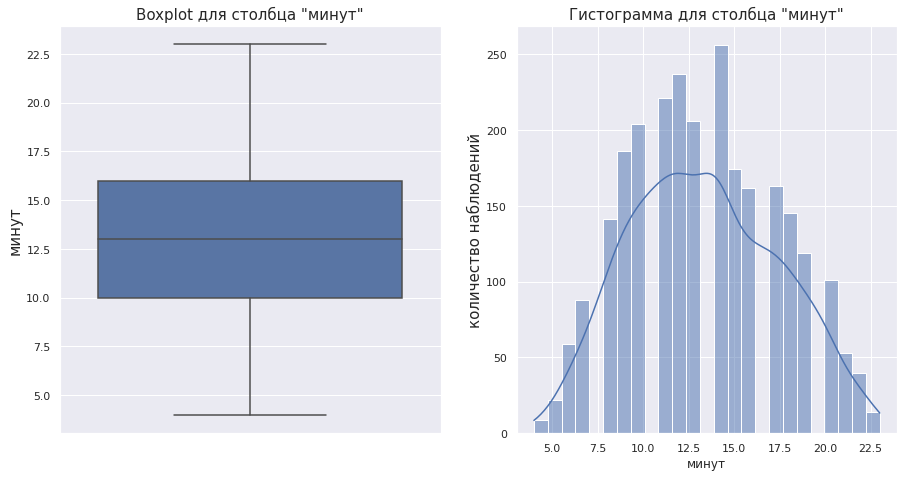

In [ ]:
boxplot_and_histplot_construct(market_time, 'минут')

### Исследовательский анализ данных четвертой таблицы

In [ ]:
money.describe()

,id,прибыль
count,1300.00,1300.00
mean,215997.50,4.00
std,375.42,1.01
min,215348.00,0.86
25%,215672.75,3.30
50%,215997.50,4.04
75%,216322.25,4.67
max,216647.00,7.43


<p>Анализ по столбцам:</p>
    <ul>
        <li>прибыль - без аномалий (выбросов)</li>
    </ul>

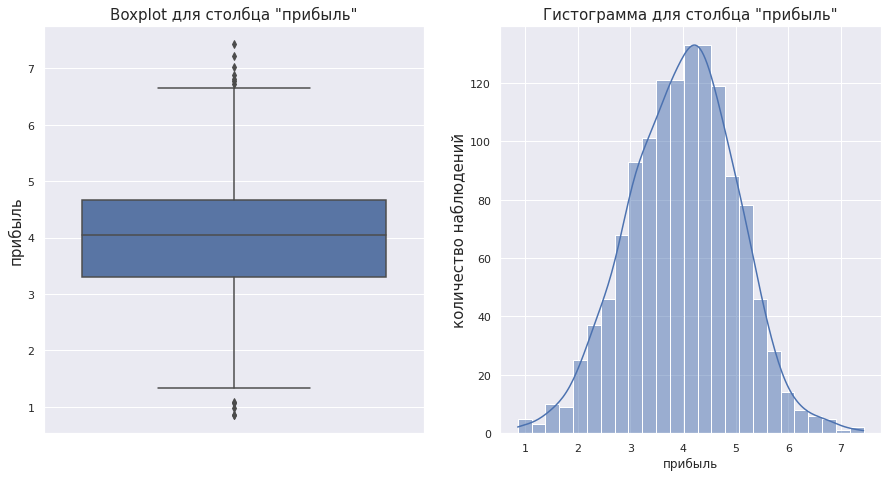

In [ ]:
boxplot_and_histplot_construct(money, 'прибыль')

### Отбор активных клиентов (осуществивших покупку за последние 3 месяца)

Отберем id клиентов с активностью за 3 месяца (т.е. осуществивших покупку в этот период). Отфильтруем id клиентов, хоть в одном из месяцев обеспечивших нулевую выручку, т.е. ничего не купивших.

In [ ]:
bad_clients = market_money.loc[market_money['выручка'] == 0, 'id'].reset_index()
bad_clients_id = bad_clients['id'].unique()

In [ ]:
print(f'Число неактивных клиентов - {len(bad_clients_id)}')

Число неактивных клиентов - 3


Отфильтруем данных клиентов из датасетов

In [ ]:
market_file = market_file.loc[~market_file['id'].isin(bad_clients_id)]
market_money = market_money.loc[~market_money['id'].isin(bad_clients_id)]
market_time = market_time.loc[~market_time['id'].isin(bad_clients_id)]
money = money.loc[~money['id'].isin(bad_clients_id)]

### Промежуточный вывод по исследовательскому анализу данных (EDA)

<p>EDA по первой таблице</p>
<p>Показано, что в значениях 'маркет_актив_6_мес' выделется небольшая группа клиентов, в отношении которых оказывали малую марк. активность в 1-2 балла. Но вввиду ее малочисленности разбивать значения на 2 категории 'марк_активные' и 'марк_не_активные'</p>
<p>Обращает на себя внимание существнная разности по популярности категорий товаров, что можно использовать для составления пользовательских профилей и формирования персонализированных маркетинговых предложений.</p>

<p>EDA по второй таблице</p>
<p>Наблюдаем выбросы по сверхвысоким (на порядки превышающим медианное) значение выручек - выделили таких  клиентов в отдельный сегмент</p>

<p>EDA по третьей таблице</p>
<p>Большинство клиентов тратят около 13 минут на сайте. Выбросов не обнаружено. </p>

<p>EDA по четвертой таблице</p>
<p>Большинство клиентов приносят прибыль в размере 4 баллов. Выбросов не обнаружено.</p>

## Объединение таблиц

Разобьем значения столбцов 'выручка' и 'минуты' по месяцам

In [ ]:
market_money_group = market_money.pivot_table(index='id', columns='период').reset_index()
market_money_group.columns = market_money_group.columns.droplevel(0)
market_money_group.columns = ['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_group = market_money_group[['id', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']]
market_money_group.columns = ['id', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']
market_money_group

,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215349,4472.0,5216.0,4971.6
1,215350,4826.0,5457.5,5058.4
2,215351,4793.0,6158.0,6610.4
3,215352,4594.0,5807.5,5872.5
4,215353,5124.0,4738.5,5388.5
...,...,...,...,...
1292,216643,4704.0,3664.0,4741.7
1293,216644,5299.0,4729.0,5353.0
1294,216645,5334.0,5160.0,5139.2
1295,216646,4725.0,4923.0,5224.6


In [ ]:
market_time_group = market_time.pivot_table(index='id', columns='период').reset_index()
market_time_group.columns = market_time_group.columns.droplevel(0)
market_time_group.columns = ['id', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_group

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10
...,...,...,...
1292,216643,14,7
1293,216644,12,11
1294,216645,12,18
1295,216646,18,7


Объединим таблицы

In [ ]:
merged_df = market_file.merge(market_money_group, on='id', how='left') \
                .merge(market_time_group, on='id', how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 0 to 1284
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1285 non-null   int64  
 1   покупательская_активность            1285 non-null   object 
 2   тип_сервиса                          1285 non-null   object 
 3   разрешить_сообщать                   1285 non-null   object 
 4   маркет_актив_6_мес                   1285 non-null   float64
 5   маркет_актив_тек_мес                 1285 non-null   int64  
 6   длительность                         1285 non-null   int64  
 7   акционные_покупки                    1285 non-null   float64
 8   популярная_категория                 1285 non-null   object 
 9   средний_просмотр_категорий_за_визит  1285 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1285 non-null   int64  
 11  ошибка_сервиса                

In [ ]:
merged_df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


## Корреляционный анализ

In [ ]:
merged_df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


Вручную отсортируем столбцы на численные непрерывные, численные дискретные и категориальные

In [ ]:
interval_columns = [
    'маркет_актив_6_мес',
    'длительность',
    'акционные_покупки',
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц',
    'выручка_текущий_месяц'
]

discrete_columns = [
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц'   
]

category_columns = [
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория'
]

Размер матрицы (17, 17)


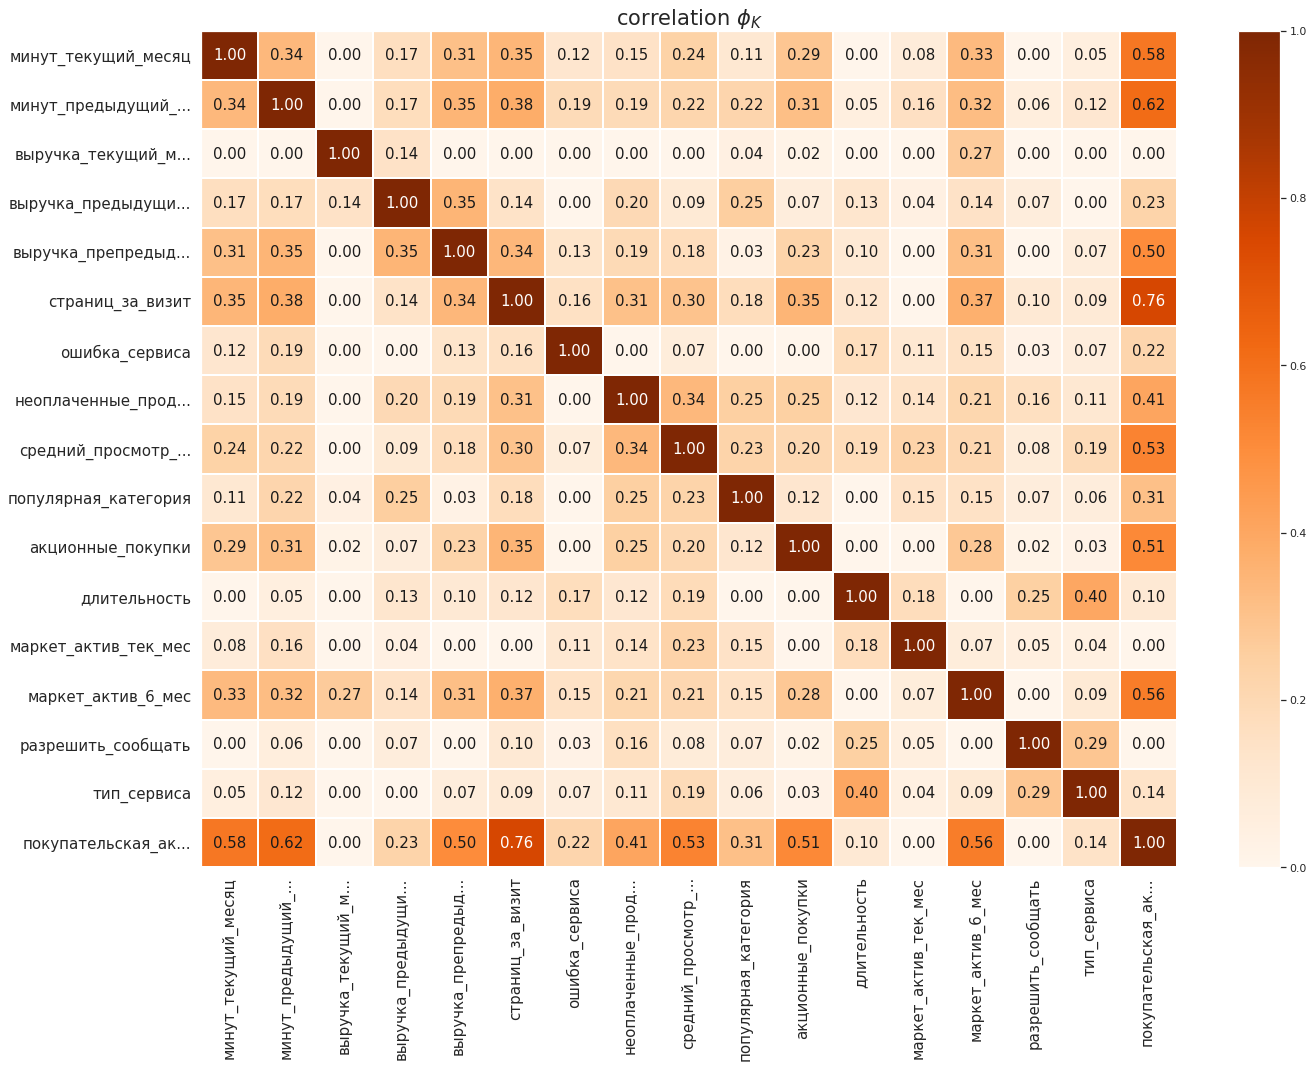

In [ ]:
merged_df_drop_id = merged_df.copy()
merged_df_drop_id.drop('id', axis=1, inplace=True)

phik_overview = merged_df_drop_id.phik_matrix(interval_cols=interval_columns)
print(f'Размер матрицы {phik_overview.shape}')
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

In [ ]:
merged_df_drop_id

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,прежний_уровень,стандарт,да,6.6,3,318,0.24,техника_для_красоты_и_здоровья,5,3,3,11,4704.0,3664.0,4741.7,14,7
1281,прежний_уровень,стандарт,нет,5.1,4,454,0.21,домашний_текстиль,6,2,3,9,5299.0,4729.0,5353.0,12,11
1282,прежний_уровень,стандарт,да,4.1,3,586,0.20,домашний_текстиль,3,2,5,7,5334.0,5160.0,5139.2,12,18
1283,прежний_уровень,стандарт,да,6.3,5,645,0.12,техника_для_красоты_и_здоровья,3,3,5,7,4725.0,4923.0,5224.6,18,7


In [ ]:
mask = phik_overview > 0.5
correlated_features = []

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask.iloc[i, j] and i != j:
            correlated_features.append((phik_overview.index[i], phik_overview.columns[j], phik_overview.iloc[i, j]))
correlated_df = pd.DataFrame(correlated_features, columns=['Feature 1', 'Feature 2', 'Correlation'])
correlated_df.sort_values(by='Correlation', ascending=False)

,Feature 1,Feature 2,Correlation
3,покупательская_активность,страниц_за_визит,0.76
10,страниц_за_визит,покупательская_активность,0.76
5,покупательская_активность,минут_предыдущий_месяц,0.62
12,минут_предыдущий_месяц,покупательская_активность,0.62
6,покупательская_активность,минут_текущий_месяц,0.58
13,минут_текущий_месяц,покупательская_активность,0.58
0,покупательская_активность,маркет_актив_6_мес,0.56
7,маркет_актив_6_мес,покупательская_активность,0.56
2,покупательская_активность,средний_просмотр_категорий_за_визит,0.53
9,средний_просмотр_категорий_за_визит,покупательская_активность,0.53


Наблюдаем высокую корреляцию (величина более 0.5) таких признаков как выручки за текущий и предыдущиц месяц, а также 'покупательская активность' и 'страниц за визит'/'минут_предыдущий_месяц'/'маркет_актив_6_мес'/'средний_просмотр_категорий_за_визит'/'неоплаченные_продукты_штук_квартал'/'акционные_покупки'

Наблюдаем некоторую мультиколлинеарность между числом просмотренных страниц и потраченном времени на сайте. Так как у нас уже есть признак среднее число просмотренных за визит категорий, мы можем удалить признак со страницами как мультиколлинеарный.

In [ ]:
merged_df = merged_df.drop(columns = 'страниц_за_визит')

## Использование пайплайнов

Построим пайплайн по подготовке данных и определим  качество модели дерева решений на метрике roc-auc. Примем получившееся значение за базовое.

Зададим id клиентов как индексы, так как их значения не несут смысловой нагрузки, но однозначно идентифицируют клиента.

In [ ]:
merged_df = merged_df.set_index('id')

Кодируем признаки 'покупательская_активность' и 'акционные_покупки' в числовые.

Выделим категориальные номинальные, категориальные порядковые и числовые непрерывные признаки.

In [ ]:
ohe_columns = [
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория'
]

ord_columns = [
    'акционные_покупки',
    'маркет_актив_тек_мес',
    'маркет_актив_6_мес',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц'
]

num_columns = [
    'длительность',
    'средний_просмотр_категорий_за_визит',
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц',
    'выручка_текущий_месяц'
]

In [ ]:
def ord_column_category(df, ord_column):
    categories = df[ord_column].unique()
    return sorted(list(categories))

Так как в дальнейшей работе планируется использовать кросс-валидацию, выборку делим только на тренировочную и тестовую (прим. далее обозначается как тестово-валидационная).

In [ ]:
X = merged_df.drop(columns='покупательская_активность')
y = merged_df['покупательская_активность']

In [ ]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y,
  test_size=0.2,
  random_state=RANDOM_STATE,
  stratify=y)

# X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid,
#  test_size=0.5,
#  random_state=RANDOM_STATE,
#  stratify=y_test_valid)

print(f'Строк X_train {len(X_train)}')
print(f'Строк X_test_valid {len(X_test_valid)}')
# print(f'Строк X_valid {len(X_valid)}')
# print(f'Строк X_test {len(X_test)}')
print()
print(f'Строк y_train {len(y_train)}')
print(f'Строк y_test_valid {len(y_test_valid)}')
# print(f'Строк y_valid {len(y_valid)}')
# print(f'Строк X_test {len(X_test)}')

Строк X_train 1028
Строк X_test_valid 257

Строк y_train 1028
Строк y_test_valid 257


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test_valid = label_encoder.transform(y_test_valid)
y_test_valid

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0])

Задаем пайплайн по подготовке данных с деревом решений как моделью по умолчанию.

In [ ]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ord_column_category(merged_df, ord_columns[0]),
                    ord_column_category(merged_df, ord_columns[1]),
                    ord_column_category(merged_df, ord_columns[2]),
                    ord_column_category(merged_df, ord_columns[3]),
                    ord_column_category(merged_df, ord_columns[4]),
                    ord_column_category(merged_df, ord_columns[5]),
                    ord_column_category(merged_df, ord_columns[6]),
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ]
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Отдельно сохраняем подготовленные данные по всем выборкам.

In [ ]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_valid_p = pd.DataFrame(
    data_preprocessor.transform(X_test_valid),
    columns=data_preprocessor.get_feature_names_out()
)

# X_valid_p = pd.DataFrame(
#     data_preprocessor.transform(X_valid),
#     columns=data_preprocessor.get_feature_names_out()
# )

# X_test_p = pd.DataFrame(
#     data_preprocessor.transform(X_test),
#     columns=data_preprocessor.get_feature_names_out()    
# )
print('X_train_p', '\n')
print(X_train_p.head(3), '\n')
print('X_test_valid_p_p', '\n')
print(X_test_valid_p.head(3), '\n')
# print('X_valid_p', '\n')
# print(X_valid_p.head(3), '\n')
# print('X_test_p', '\n')
# print(X_test_p.head(3), '\n')

X_train_p 

   ohe__тип_сервиса_стандарт  ohe__разрешить_сообщать_нет  \
0  1.0                        0.0                           
1  1.0                        0.0                           
2  1.0                        1.0                           

   ohe__популярная_категория_косметика_и_аксессуары  \
0  0.0                                                
1  0.0                                                
2  0.0                                                

   ohe__популярная_категория_кухонная_посуда  \
0  0.0                                         
1  1.0                                         
2  0.0                                         

   ohe__популярная_категория_мелкая_бытовая_техника_и_электроника  \
0  1.0                                                              
1  0.0                                                              
2  1.0                                                              

   ohe__популярная_категория_техника_для_красоты_и_з

Есть несколько причин использовать ROC-AUC в качестве основной метрики оценки качества моделей в данном исследовании:
<ul>
<li>ROC-AUC эффективна, когда у таргета несбалансированные классы</li>
<li>ROC-AUC не зависит от порога классификации и учитывает соотношение истинно положительных (True Positive Rate, TPR) и ложноположительных (False Positive Rate, FPR) прогнозов</li>
<li>ROC-AUC полезна, если нужно соблюдать компромисс между истинно положительными (TPR) и ложноположительными (FPR) прогнозами</li>

Обучим базовую модель и выведем метрики ROC-AUC как основную (в качестве интегральной по всем thresholds) и F1-score как вспомогательную.  

In [ ]:
pipe_final.fit(X_train, y_train)

y_test_valid_pred = pipe_final.predict(X_test_valid)
y_test_valid_pred_proba = pipe_final.predict_proba(X_test_valid)[:, 1]

# y_valid_pred = pipe_final.predict(X_valid)
# y_valid_pred_proba = pipe_final.predict_proba(X_valid)[:, 1]

# y_test_pred = pipe_final.predict(X_test)
# y_test_pred_proba = pipe_final.predict_proba(X_test)[:, 1]

print('Качество базовой модели', '\n')
print()
print(f'Метрика ROC-AUC на тестово-валидационной выборке: {roc_auc_score(y_test_valid, y_test_valid_pred_proba)}')
print(f'Метрика F1-score на тестово-валидационной выборке: {f1_score(y_test_valid, y_test_valid_pred)}')
print()
# print(f'Метрика ROC-AUC на валидационной выборке: {roc_auc_score(y_valid, y_valid_pred_proba)}')
# print(f'Метрика F1-score на валидационной выборке: {f1_score(y_valid, y_valid_pred).round(2)}')
# print()
# print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba)}')
# print(f'Метрика F1-score на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Качество базовой модели 


Метрика ROC-AUC на тестово-валидационной выборке: 0.7805090206185566
Метрика F1-score на тестово-валидационной выборке: 0.7272727272727273



Наблюдаем достаточно высокое качество модели даже на базовой модели.

Осуществим перебор моделей логистической регрессии, опорных векторов, K-ближайших соседей и дерева решений с отбором самой эффективной модели через последовательный автоматизированный поиск. 

In [ ]:
param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'models' : [
        LogisticRegression(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        DecisionTreeClassifier(random_state=RANDOM_STATE)
    ]
} 

Обучим модель на тренировочных данных при кросс-валидации на 5 блоках. 

In [ ]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', grid_search.best_score_)
print()
print('Результаты')
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
print()

y_test_valid_pred = grid_search.best_estimator_.predict(X_test_valid)
y_test_valid_pred_proba = grid_search.best_estimator_.predict_proba(X_test_valid)[:, 1]
# y_valid_pred = grid_search.best_estimator_.predict(X_valid)
# y_valid_pred_proba = grid_search.best_estimator_.predict_proba(X_valid)[:, 1]
# y_test_pred = grid_search.best_estimator_.predict(X_test)
# y_test_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

print('Качество опытной модели', '\n')
print()
print(f'Метрика ROC-AUC на тестово-валидационной выборке: {roc_auc_score(y_test_valid, y_test_valid_pred_proba)}')
print(f'Метрика F1-score на тестово-валидационной выборке: {f1_score(y_test_valid, y_test_valid_pred)}')
print()
# print(f'Метрика ROC-AUC на валидационной выборке: {roc_auc_score(y_valid, y_valid_pred_proba)}')
# print(f'Метрика F1-score на валидационной выборке: {f1_score(y_valid, y_valid_pred)}')
# print()
# print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba)}')
# print(f'Метрика F1-score на тестовой выборке: {f1_score(y_test, y_test_pred)}')

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                  

Наиболее эффективной моделью оказалась модель логистической регрессии.

Дополнительно подберем гиперпараметры через рандомизированный автоматизированный поиск (для ускорения рассчетов по сравнению с полным поиском). Для модели логистической регрессии будем варьировать строгость регуляризации, для модели метода опорных векторов - степень полинома, для модели K-ближайших соседей будем варьировать число соседенй, для дерева решений - глубину дерева. 

In [ ]:
param_distributions = [
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier()],
        'models__max_depth': [None, 10, 20, 30],
        'models__min_samples_split': [2, 5, 10, 15],
        'models__min_samples_leaf': [1, 2, 4, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [RandomForestRegressor()],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [None, 10, 20, 30],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Обучим модель на тренировочных данных при кросс-валидации на 5 блоках. 

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='r2',  # Измените на соответствующую метрику для регрессии
    random_state=RANDOM_STATE,
    n_jobs=-1
)



print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

print()
print('Результаты')
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
print()

y_test_valid_pred = randomized_search.best_estimator_.predict(X_test_valid)
y_test_valid_pred_proba = randomized_search.best_estimator_.predict_proba(X_test_valid)[:, 1]
# y_valid_pred = randomized_search.best_estimator_.predict(X_valid)
# y_valid_pred_proba = randomized_search.best_estimator_.predict_proba(X_valid)[:, 1]
# y_test_pred = randomized_search.best_estimator_.predict(X_test)
# y_test_pred_proba = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]

print('Качество опытной модели', '\n')
print()
print(f'Метрика ROC-AUC на тестово-валидационной выборке: {roc_auc_score(y_test_valid, y_test_valid_pred_proba)}')
print(f'Метрика F1-score на тестово-валидационной выборке: {f1_score(y_test_valid, y_test_valid_pred)}')
print()
# print(f'Метрика ROC-AUC на валидационной выборке: {roc_auc_score(y_valid, y_valid_pred_proba)}')
# print(f'Метрика F1-score на валидационной выборке: {f1_score(y_valid, y_valid_pred)}')
# print()
# print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba)}')
# print(f'Метрика F1-score на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Лучша модель по прогнозу покупательской активности - LogisticRegression() со скейлером StandardScaler() и гиперпараметром C = 31. Качество модели с подобранным гиперпараметров выросло, но незначительно. Зададим данную модель в качестве итоговой как наиболее эффективную.

In [ ]:
final_model = LogisticRegression(random_state=RANDOM_STATE, C = 31)
final_model.fit(X_train_p, y_train)
y_test_valid_p_pred = final_model.predict(X_test_valid_p)
y_test_valid_p_pred_proba = final_model.predict_proba(X_test_valid_p)[:, 1]

print(f'Метрика ROC-AUC на тестово-валидационной выборке: {roc_auc_score(y_test_valid, y_test_valid_p_pred_proba)}')
print(f'Метрика F1-score на тестово-валидационной выборке: {f1_score(y_test_valid, y_test_valid_p_pred)}')

Определим комбинации признаков, на которых отобранная модель показывает наилучшие результаты.

In [ ]:
roc_aucs = []
f_scores = []
features_names = []

for i in range(1, len(X_train_p.columns) + 1):
    selector = SelectKBest(f_classif, k=i)
    selector.fit(X_train_p, y_train)
    f_n = selector.get_feature_names_out()
    
    X_train_p_new = X_train_p[f_n]
    X_test_valid_p_new = X_test_valid_p[f_n]

    final_model.fit(X_train_p_new, y_train)
    y_test_valid_p_pred = final_model.predict(X_test_valid_p_new)
    y_test_valid_p_pred_proba = final_model.predict_proba(X_test_valid_p_new)[:, 1]
    
    rc_ac = roc_auc_score(y_test_valid, y_test_valid_p_pred_proba)
    f1_sc = f1_score(y_test_valid, y_test_valid_p_pred)
    
    features_names.append(f_n)
    roc_aucs.append(rc_ac)
    f_scores.append(f1_sc)

combined = list(zip(roc_aucs, f_scores, features_names))
sorted_combined = sorted(combined, key=lambda x: (x[0], x[1]), reverse=True)
print(f'Наилучший результат показан на {len(sorted_combined[0][2])} из {len(X_train_p.columns)} подготовленных признаках')
sorted_combined[0]

Удалось несколько повысить предсказательные способности модели посредством фльтрации подготовленных признаков с 19 до 14.

## Анализ важности признаков

Проанализируем важность признаков на примере значений SHAP

In [ ]:
explainer = shap.LinearExplainer(final_model, X_train_p_new)
shap_values = explainer(X_train_p_new)

In [ ]:
shap.plots.beeswarm(shap_values) 

<p>Сводный график величин SHAP по признакам достаточно наглядный, в частности показано, что величина SHAP растет (т.е. в контексте исследования увеличивает вероятность снижения покупательской активности) при:</p>
<ul>
    <li>При росте ord_акционные_покупки</li>
    <li>При росте ord_неоплаченные_продукты_штук_квартал</li>
    <p></p>
    <li>При снижении ord_минут_предыдущий_месяц</li>
    <li>При снижении num_средниц_просмотр_категорий_за_визит</li>
    <li>При снижении ord_market_актив_6_мес</li>
    <li>При снижении ord_минут_текущий месяц</li>
    <li>При снижении ohe_популярная_категория_мелкая_бытовая_техника_и-электроника</li>
    <li>При снижении num_выручка_предпредыдущий_месяц</li>
</ul>

При этом, самыми значимыми признаками являются число просмотреных за визит страниц и категорий, а также число потраченных минут, т.е. активность на сайте. Акционные покупки также оказывают существенное влияние но, как показано выше, скорее повышают вероятность снижения покупательской активности клиента.

Значения SHAP по отельным наблюдениям ожидаемо варьируют.

In [ ]:
shap.plots.waterfall(shap_values[0]) 

In [ ]:
shap.plots.waterfall(shap_values[1]) 

Вышеуказанные зависимости можно пронаблюдать и на графиках зависимостей SHAP от величин отдельных признаков. Показано, что активность на сайте снижает вероятность оттока. а акионные покупки, напротив. его повышают.

In [ ]:
shap.plots.scatter(shap_values[:, 'num__средний_просмотр_категорий_за_визит'])

In [ ]:
shap.plots.scatter(shap_values[:, 'ord__акционные_покупки'])

## Сегментация покупателей

Объединим общий датасет с показателями по прибыльности клиентов посредством левого соединения

In [ ]:
merged_df_money = merged_df.reset_index().copy().merge(money, on='id', how='left')
merged_df_money.info()

Выведем описательную статистику по прибыльности клиентов

In [ ]:
merged_df_money['прибыль'].describe()

Наблюдаем, что медианная прибыльность составляет около 4.04.

In [ ]:
merged_df_money_drop_id = merged_df_money.copy()
merged_df_money_drop_id.drop('id', axis=1, inplace=True)

phik_overview = merged_df_money_drop_id.phik_matrix(interval_cols=interval_columns)
print(phik_overview.shape)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Наблюдаем, что прибыльность слабо скоррелирована с прибыльностью за предыдущие месяца и маркетинговой активности.

По результатам предыдущего анализа выделем 2 сегмента клиентов с пониженным и повышенным оттоком, а именно с высокой активностью на сайте (пониженный отток) и склонных к импульсивным покупкам (повышенный отток). В первый сегмент войдут клиенты с высокими показателями 'станиц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий месяц',  'средний_просмотр_категорий_за_визит', 'минут_текущий месяц'. Во вторую группу войдут пользователи с высокими показателями 'акционные_покупки' и 'неоплаченные_продукты_штук_квартал'.

In [ ]:
merged_df_money_first = merged_df_money.loc[
    (merged_df_money['минут_предыдущий_месяц'] > merged_df_money['минут_предыдущий_месяц'].median()) &
    (merged_df_money['минут_текущий_месяц'] > merged_df_money['минут_текущий_месяц'].median()) &
    (merged_df_money['средний_просмотр_категорий_за_визит'] > merged_df_money['средний_просмотр_категорий_за_визит'].median())
]
merged_df_money_first.info()

In [ ]:
merged_df_money_first['покупательская_активность'].describe()

In [ ]:
merged_df_money_first['прибыль'].describe()

In [ ]:
merged_df_money_second = merged_df_money.loc[
    (merged_df_money['акционные_покупки'] > merged_df_money['акционные_покупки'].median()) &
    (merged_df_money['неоплаченные_продукты_штук_квартал'] > merged_df_money['неоплаченные_продукты_штук_квартал'].median())
]
merged_df_money_second.info()

In [ ]:
merged_df_money_second['покупательская_активность'].describe()

In [ ]:
merged_df_money_second['прибыль'].describe()

Наблюдаем, что сформированные группы контрастно отличаются по вероятности оттока, но совершенно несущественно отличаются по прибыльности. С учетом того, что привлекать новых клиентов существенно дороже, акционные покупки формируют нелояльных клиентов с прибыльностью на уровне лояльных, вероятно стоит отказаться от подобных акций в пользу методов повышения прибыльности уже лояльных клиентов.

## Общий вывод

Цель исследования - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Исходные данные, предоставленные для проведения анализа оттока клиентов в зависимости от параметров их пользовательских профилей, были представлены в формате 3 датасетов. Датасеты характеризовались отностиельно высоким качеством, с отсутствием пропусков и минимальным количеством дубликатов, выбросов и ошибок в типах данных. Данные были предобработаны, дубли и выбросы удалены, названия столбцов изменены на более корректные.

В процессе исследовательского анализа данных были отфильтрованы клиенты с аномальными значениями выручки. Показано, что всего 70 клиентов из 1300 не были активны за все 3 месяца.

При объединении таблиц наблюдаем появление пропусков там, где в исходном датафрейме отсутствуют данные по соответствующему месяцу. Вероятнее всего, выручка по данным клиентам по данным месяцам равна 0. Заполнили пропуски соответствующими значениями.

Наблюдали высокую корреляцию (величина более 0.5) таких признаков как выручки за текущий и предыдущиц месяц, а также 'покупательская активность' и 'страниц за визит'/'минут'/'маркет_актив_6_мес'/'средний_просмотр_категорий_за_визит'/'неоплаченные_продукты_штук_квартал'/'акционные_покупки'

Для прогноза вероятности оттока клиентов по параметрам пользовательского-профиля формировали и испытывали соответствующие модели. Дополнительно подбирали гиперпараметры через рандомизированный автоматизированный поиск (для ускорения рассчетов по сравнению с полным поиском). Для модели логистической регрессии варьировали строгость регуляризации, для модели метода опорных векторов - степень полинома, для модели K-ближайших соседей варьировали число соседенй, для дерева решений - глубину дерева. 

По итогам оптимизации была отобрана лучша модель по прогнозу покупательской активности - LogisticRegression() со скейлером StandardScaler() и гиперпараметром C = 31. Качество модели с подобранным гиперпараметров выросло, но незначительно. Задали данную модель в качестве итоговой как наиболее эффективную. Результаты испытаний модели показаны ниже.

Качество опытной модели:
Метрика ROC-AUC на тестово-валидационной выборке: 0.9318943298969072
Метрика F1-score на тестово-валидационной выборке: 0.8333333333333334

Дополнительно отфильтровали признаки, тем самым повысив качество модели. <p>Наилучший результат показан на 14 из 19 подготовленных признаках</p>

<p>Сводный график величин SHAP по признакам достаточно наглядный, в частности показано, что величина SHAP растет (т.е. в контексте исследования увеличивает вероятность снижения покупательской активности) при:</p>
<ul>
    <li>При росте ord_акционные_покупки</li>
    <li>При росте ord_неоплаченные_продукты_штук_квартал</li>
    <p></p>
    <li>При снижении ord_минут_предыдущий_месяц</li>
    <li>При снижении num_средниц_просмотр_категорий_за_визит</li>
    <li>При снижении ord_market_актив_6_мес</li>
    <li>При снижении ord_минут_текущий месяц</li>
    <li>При снижении ohe_популярная_категория_мелкая_бытовая_техника_и-электроника</li>
    <li>При снижении num_выручка_предпредыдущий_месяц</li>
</ul>

При этом, самыми значимыми признаками являются число просмотреных за визит страниц и категорий, а также число потраченных минут, т.е. активность на сайте. Акционные покупки также оказывают существенное влияние но, как показано выше, скорее повышают вероятность снижения покупательской активности клиента.

Для сегментации покупателей объединили общий датасет с показателями по прибыльности клиентов посредством левого соединения. Пронаблюдали, что медианная прибыльность составляет около 4.04 и слабо скоррелирована с прибыльностью за предыдущие месяца и маркетинговой активности.

По результатам предыдущего анализа выделем 2 сегмента клиентов с пониженным и повышенным оттоком, а именно с высокой активностью на сайте (пониженный отток) и склонных к импульсивным покупкам (повышенный отток). В первый сегмент войдут клиенты с высокими показателями 'станиц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий месяц',  'средний_просмотр_категорий_за_визит', 'минут_текущий месяц'. Во вторую группу войдут пользователи с высокими показателями 'акционные_покупки' и 'неоплаченные_продукты_штук_квартал'.

Наблюдаем, что сформированные группы контрастно отличаются по вероятности оттока, но совершенно несущественно отличаются по прибыльности. С учетом того, что привлекать новых клиентов существенно дороже, акционные покупки формируют нелояльных клиентов с прибыльностью на уровне лояльных, вероятно стоит отказаться от подобных акций в пользу методов повышения прибыльности уже лояльных клиентов, а так же провести маркетинговые мероприятия по улучшению пользовательского опыта от 'общения' с сайтом как определяющего вероятность оттока.